In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from random import shuffle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.models import Model
from keras.callbacks import CSVLogger
from keras.layers import BatchNormalization
from sklearn.metrics import f1_score
from gensim.models import KeyedVectors
import gensim
import json
import warnings
import logging, sys
import os
from datetime import datetime
logging.disable(sys.maxsize)
warnings.filterwarnings('ignore')


In [4]:
train_data = pd.read_csv('/content/drive/MyDrive/sarthi/train_data.csv')
valid_data = pd.read_csv('/content/drive/MyDrive/sarthi/valid_data.csv')
valid_data.drop('path', inplace=True, axis=1)
train_data.drop('path', inplace=True, axis=1)


In [5]:
# Checking Null value
train_data.isnull().any()
valid_data.isnull().any()

transcription    False
action           False
object           False
location         False
dtype: bool

In [6]:
# Finding out how many unique value train set have 
print(train_data['action'].unique(),train_data['object'].unique(), train_data['location'].unique(), sep = "\n\n")

['activate' 'increase' 'change language' 'decrease' 'deactivate' 'bring']

['lights' 'heat' 'Chinese' 'none' 'volume' 'English' 'lamp' 'shoes'
 'newspaper' 'socks' 'music' 'Korean' 'juice' 'German']

['kitchen' 'none' 'washroom' 'bedroom']


In [7]:
# Here we can use pd.Categorical(valid_data['action']) 

act_encoder = OneHotEncoder(sparse=False, dtype='int32', handle_unknown='ignore')
obj_encoder = OneHotEncoder(sparse=False, dtype='int32', handle_unknown='ignore')
loc_encoder = OneHotEncoder(sparse=False, dtype='int32', handle_unknown='ignore')

act_oh = act_encoder.fit_transform(np.array(train_data['action']).reshape(-1,1))
obj_oh = obj_encoder.fit_transform(np.array(train_data['object']).reshape(-1,1))
loc_oh = loc_encoder.fit_transform(np.array(train_data['location']).reshape(-1,1))
train_data['act'] = list(act_oh)
train_data['obj'] = list(obj_oh)
train_data['loc'] = list(loc_oh)
# train_data['class']=train_data['act_oh']
# for i in range(len(train_data)):
#   train_data['class'].iloc[i]= list(train_data['act_oh'].iloc[i])+list(train_data['obj_oh'].iloc[i])+list(train_data['loc_oh'].iloc[i])

train_data.head()

,transcription,action,object,location,act,obj,loc
0,Turn on the kitchen lights,activate,lights,kitchen,"[1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0]"
1,Turn up the temperature,increase,heat,none,"[0, 0, 0, 0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0]"
2,OK now switch the main language to Chinese,change language,Chinese,none,"[0, 0, 1, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0]"
3,Turn down the bathroom temperature,decrease,heat,washroom,"[0, 0, 0, 0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1]"
4,Change the language,change language,none,none,"[0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]","[0, 0, 1, 0]"


In [8]:
# Using transcription 
import re
import unicodedata
import string
import spacy

nlp = spacy.load('en_core_web_sm')

def clean1(text, accented=True, special=True, punctuation = True):
  if accented:
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  if punctuation:
    text = ''.join([c for c in text if c not in string.punctuation])
  if special:
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    text = re.sub(pat, '', text)
  return text.lower()
  
def stopword(text):
  # text = nlp(text)
  stopwords = nlp.Defaults.stop_words
  lst=[]
  for token in text.split():
      if token.lower() not in stopwords:    #checking whether the word is not 
          lst.append(token)                    #present in the stopword list.
  text = ' '.join(lst)
  return text

In [9]:
train_data['transcription'] = train_data['transcription'].apply(clean1)
valid_data['transcription'] = valid_data['transcription'].apply(stopword)
train_data['transcription'] = train_data['transcription'].apply(stopword)
valid_data['transcription'] = valid_data['transcription'].apply(clean1)
train_data.head()
# valid_data.head()

,transcription,action,object,location,act,obj,loc
0,turn kitchen lights,activate,lights,kitchen,"[1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0]"
1,turn temperature,increase,heat,none,"[0, 0, 0, 0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0]"
2,ok switch main language chinese,change language,Chinese,none,"[0, 0, 1, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0]"
3,turn bathroom temperature,decrease,heat,washroom,"[0, 0, 0, 0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1]"
4,change language,change language,none,none,"[0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]","[0, 0, 1, 0]"


In [10]:
vocab_size = 5000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_data['transcription'])
token_train = tokenizer.texts_to_sequences(train_data['transcription'])
token_valid = tokenizer.texts_to_sequences(valid_data['transcription'])
vocab_size = len(tokenizer.word_index) + 1


In [11]:
# As the length of arrays are diffrent we need to pad it
max_length = 200
train_data['padded_sequences'] = pad_sequences(token_train,  padding='post', maxlen=max_length).tolist()
train = np.array([np.array(i) for i in train_data['padded_sequences']])
valid_data['padded_sequences'] = pad_sequences(token_valid,  padding='post', maxlen=max_length).tolist()
valid = np.array([np.array(i) for i in train_data['padded_sequences']])


In [12]:
! wget "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip"
!unzip "./wiki-news-300d-1M.vec.zip"

--2021-12-04 23:34:24--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip.1’

      wiki-news-300   1%[                    ]   8.96M  10.7MB/s               ^C
Archive:  ./wiki-news-300d-1M.vec.zip
replace wiki-news-300d-1M.vec? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [14]:
from gensim.models import KeyedVectors
e_model = KeyedVectors.load_word2vec_format('wiki-news-300d-1M.vec')
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index)+1, 300))
for word, i in word_index.items():
    try:    
      embedding_vector = e_model[word]
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector
    except:
      embedding_matrix[i] = np.zeros((300,))
      print(1)

In [49]:
#In practical terms, you can use the pretrained Word2vec embeddings as features of any neural network (or other algorithm). They can give you advantage if your data is small, since the pretrained embeddings were trained on large volumes of text

In [15]:
# Treating [location,object,action] as class and training the model on them
t = pd.DataFrame()
t["all"] =train_data['act']
for i in range(len(train_data)):
  t['all'].iloc[i]= list(train_data['act'].iloc[i])+list(train_data['obj'].iloc[i])+list(train_data['loc'].iloc[i])
Y = pd.DataFrame()
for i in range(23):
  Y[i+1]=t['all'].apply(lambda x: int(x[i]))

In [16]:
# Taking X as the padded output of the tokenier
X = train


In [17]:
#seperating the data in test and train pair
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)


In [19]:
#Model
EMBEDDING_DIM = 300
embedding_layer = Embedding(vocab_size,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=10,
        trainable=False)

lstm_layer_1 = LSTM(20, return_sequences=False, dropout=0.15, recurrent_dropout=0.15)

sequence_input = Input(shape=(200,), dtype='int32')
x1 = embedding_layer(sequence_input)
x1 = lstm_layer_1(x1)
x1 = Dropout(0.10)(x1)
x1 = BatchNormalization()(x1)
x1 = Dense(500, activation='relu')(x1)
x1 = Dropout(0.10)(x1)
x1 = Dense(50, activation='relu')(x1)
x1 = Dropout(0.10)(x1)
x1 = BatchNormalization()(x1)
preds = Dense(23, activation='softmax')(x1)

model = Model(inputs=sequence_input, outputs=preds)
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 200, 300)          20700     
                                                                 
 lstm_1 (LSTM)               (None, 20)                25680     
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 batch_normalization_2 (Batc  (None, 20)               80        
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 500)               10500     
                                                           

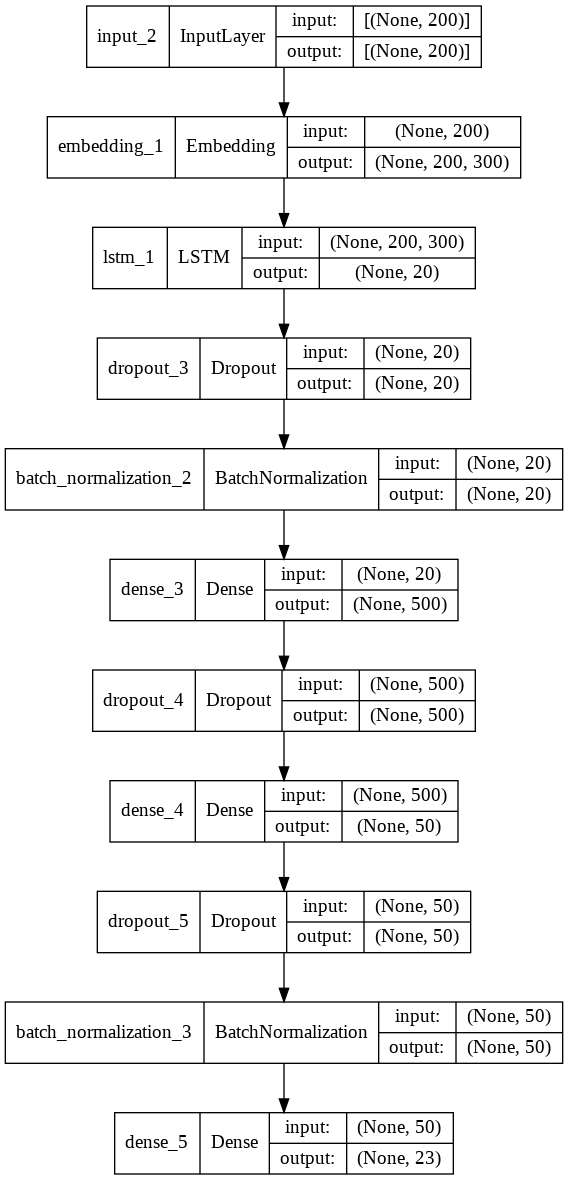

In [20]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [22]:

loss_fn = tf.keras.losses.MeanAbsoluteError()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
train_acc_metric = tf.keras.losses.MeanAbsoluteError()
val_acc_metric = tf.keras.losses.MeanAbsoluteError()

model.compile(optimizer=optimizer, loss=loss_fn, metrics=train_acc_metric)
model.fit(X_train, y_train, batch_size=1024, epochs=100, validation_data=(X_test, y_test), use_multiprocessing=True)

Epoch 1/100
8/8 [==============================] - 19s 2s/step - loss: 0.1237 - mean_absolute_error: 0.1236 - val_loss: 0.1126 - val_mean_absolute_error: 0.1128
Epoch 2/100
8/8 [==============================] - 13s 2s/step - loss: 0.1236 - mean_absolute_error: 0.1236 - val_loss: 0.1124 - val_mean_absolute_error: 0.1126
Epoch 3/100
8/8 [==============================] - 13s 2s/step - loss: 0.1234 - mean_absolute_error: 0.1235 - val_loss: 0.1123 - val_mean_absolute_error: 0.1125
Epoch 4/100
8/8 [==============================] - 12s 1s/step - loss: 0.1238 - mean_absolute_error: 0.1238 - val_loss: 0.1122 - val_mean_absolute_error: 0.1124
Epoch 5/100
8/8 [==============================] - 13s 2s/step - loss: 0.1232 - mean_absolute_error: 0.1233 - val_loss: 0.1122 - val_mean_absolute_error: 0.1124
Epoch 6/100
8/8 [==============================] - 13s 2s/step - loss: 0.1240 - mean_absolute_error: 0.1240 - val_loss: 0.1122 - val_mean_absolute_error: 0.1124
Epoch 7/100
8/8 [=================

In [24]:
test_df= valid_data

tokenizer = Tokenizer()
tokenizer.fit_on_texts(test_df['transcription'])

max_len = 200
data = tokenizer.texts_to_sequences(test_df['transcription'].values)
data = pad_sequences(data, maxlen=max_len)

preds = model.predict(data)
ans=preds
# print(ans)

test_df['act']=test_df['transcription']
test_df['obj']=test_df['transcription']
test_df['loc']=test_df['transcription']

for i in range(len(test_df)):
  temp=[]
  for j in range(6):
    temp.append(round(ans[i][j]))
  test_df['act'].iloc[i]= np.array(temp)

  temp=[]
  for j in range(4,18):
    temp.append(round(ans[i][j]))
  test_df['obj'].iloc[i]= np.array(temp)
  
  temp=[]
  for j in range(19,23):
    temp.append(round(ans[i][j]))
  test_df['loc'].iloc[i]= np.array(temp)

# print(test_df.head())

# test_df.head()

test_df['act_pred']= test_df['act'].apply(lambda x: act_encoder.inverse_transform(x.reshape(1,-1)))
test_df['obj_pred']= test_df['obj'].apply(lambda x: obj_encoder.inverse_transform(x.reshape(1,-1)))
test_df['loc_pred']= test_df['loc'].apply(lambda x: loc_encoder.inverse_transform(x.reshape(1,-1)))

test_df['act_pred']=test_df['act_pred'].apply(lambda x: x[0][0])
test_df['act_pred']=test_df['act_pred'].apply(lambda x: x if x else 'none')

test_df['obj_pred']=test_df['obj_pred'].apply(lambda x: x[0][0])
test_df['obj_pred']=test_df['obj_pred'].apply(lambda x: x if x else 'none')

test_df['loc_pred']=test_df['loc_pred'].apply(lambda x: x[0][0])
test_df['loc_pred']=test_df['loc_pred'].apply(lambda x: x if x else 'none')

# print(test_df['act_pred'].head())
# micro f1 score
action_f1 = f1_score(test_df['act_pred'],test_df['action'], average='micro')
object_f1 = f1_score(test_df['obj_pred'],test_df['object'], average='micro')
location_f1 = f1_score(test_df['loc_pred'],test_df['location'], average='micro')
print('F1 score for action-->',action_f1)
print('F1 score for object-->',object_f1)
print('F1 score for location-->',location_f1)

F1 score for action--> 0.0
F1 score for object--> 0.03784477228992944
F1 score for location--> 0.5978191148171905
